## This notebook trains the Petrelli Cpx-only barometers
- We follow Petrelli, where a different random state is used for pressure and temperature
- Note, this will likely need rerunning a lot, because it seems if sklearn changes version too much, the pickles wont load. 
- With each change in Sklearn, the answer will likely change. The change from v023.2 resulted in a change of up to ~0.8 kbar per Cpx. This is sadly unavoidable as far as we know, although if you have a suggestion please let us know!
- This was last run on April 24th 2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import warnings as w
import sys
sys.path.append("../../..")
import Thermobar as pt

In [2]:
out_train=pt.import_excel('GlobalDataset_Final_rev9_TrainValidation.xlsx',
                          sheet_name='Train_Thermobar_Format')
out_train_input=out_train['my_input']
Cpx_train=out_train['Cpxs']
Cpx_train_noID_noT=Cpx_train.drop(['Sample_ID_Cpx'], axis=1)
x_train=Cpx_train_noID_noT.values
y_train_T=out_train_input['T_K']
y_train_P=out_train_input['P_GPa']*10

In [3]:
Cpx_train

,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,Sample_ID_Cpx
0,50.42,0.62,6.72,7.21,0.19,15.55,17.27,0.61,0.01,0.0,0
1,51.14,0.61,5.31,7.68,0.15,16.36,16.34,0.81,0.04,0.0,1
2,47.40,2.51,3.62,13.83,1.78,8.13,16.40,4.37,0.04,0.0,2
3,46.10,4.23,3.78,18.91,1.79,3.92,16.72,3.77,0.03,0.0,3
4,49.90,1.30,3.21,8.80,0.88,12.80,21.30,1.73,0.00,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
845,51.50,1.17,2.57,9.16,0.18,15.90,18.90,0.25,0.00,0.0,845
846,51.40,1.36,2.05,9.92,0.19,15.60,18.40,0.26,0.00,0.0,846
847,52.50,0.74,2.47,6.59,0.17,16.90,19.90,0.21,0.00,0.0,847
848,51.70,1.10,2.84,7.29,0.13,15.70,20.60,0.28,0.00,0.0,848


In [4]:
## Test dataset
out_test=pt.import_excel('GlobalDataset_Final_rev9_TrainValidation.xlsx',
                          sheet_name='Test_Thermobar_Format')

out_test_input=out_test['my_input']
Cpx_test=out_test['Cpxs']
Cpx_test_noID_noT=Cpx_test.drop(['Sample_ID_Cpx'], axis=1)
x_test=Cpx_test_noID_noT.values
y_test_T=out_test_input['T_K']
y_test_P=out_test_input['P_GPa']*10

In [5]:
Cpx_test

,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,Sample_ID_Cpx
0,50.30,1.38,2.25,12.90,1.04,10.10,20.40,1.66,0.0,0.00,0
1,50.50,1.00,1.65,13.10,1.11,10.70,21.30,0.71,0.0,0.00,1
2,50.60,0.96,2.13,14.90,1.30,7.20,19.90,1.70,0.3,0.00,2
3,48.60,0.89,9.06,7.61,0.20,14.80,18.30,0.59,0.0,0.11,3
4,48.10,1.03,9.28,8.23,0.20,14.40,18.10,0.65,0.0,0.12,4
...,...,...,...,...,...,...,...,...,...,...,...
114,54.20,0.31,1.98,11.40,0.00,16.60,16.90,0.33,0.0,0.00,114
115,55.60,0.19,2.13,13.80,0.00,26.30,4.23,0.07,0.0,0.00,115
116,50.80,0.10,2.60,12.30,0.00,11.70,21.70,0.80,0.0,0.00,116
117,49.53,0.53,11.83,6.01,0.00,12.89,16.67,2.02,0.0,0.00,117


In [6]:
# Scaling
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)

# Define the regressor, in our case the Extra Tree Regressor
# Using the parameters from Petrelli supplement for P. Don't actually present a regression for T, 
# but we add it here.
regr_T = ExtraTreesRegressor(n_estimators=450, criterion='squared_error', max_features=10, 
                             random_state=120) # random_state fixed for reproducibility

# Define the regressor, in our case the Extra Tree Regressor
regr_P = ExtraTreesRegressor(n_estimators=450, criterion='squared_error', max_features=10, 
                             random_state=120) # random_state fixed for reproducibility

# Train the model
regr_T.fit(x_train_scaled, y_train_T.ravel())
regr_P.fit(x_train_scaled, y_train_P.ravel())

x_test_scaled=scaler.transform(x_test)

## Predicting the test data for temp

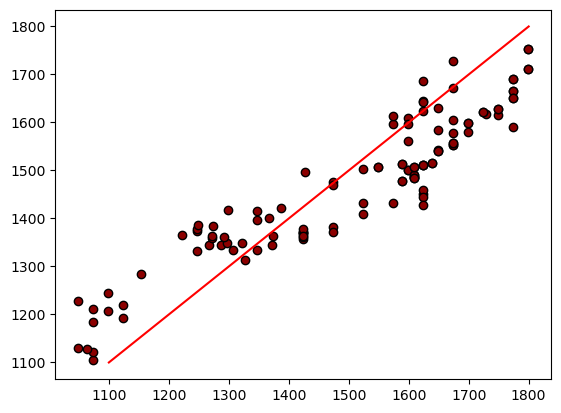

In [7]:
predicted_T=regr_T.predict(x_test_scaled)
plt.plot( y_test_T, predicted_T, 'ok', mfc='darkred')
plt.plot([1100, 1800], [1100, 1800], '-r')
Stats_T=pt.calculate_R2_np(y_test_T.values, predicted_T)


## Predicting the test data for Press

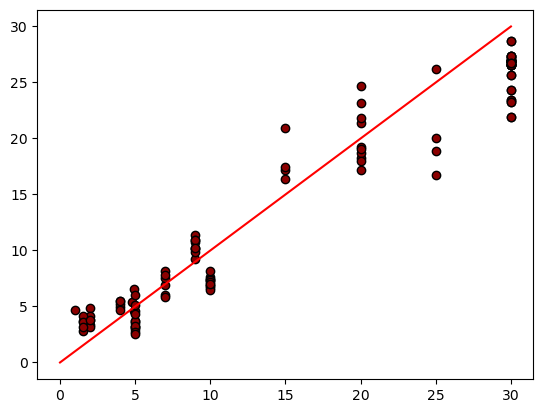

In [8]:
predicted_P=regr_P.predict(x_test_scaled)
plt.plot( y_test_P, predicted_P, 'ok', mfc='darkred')
plt.plot([0, 30], [0, 30], '-r')
Stats_P=pt.calculate_R2_np(y_test_P.values, predicted_P)


In [9]:
Stats_P=pt.calculate_R2_np(y_test_P.values, predicted_P)
print(Stats_P['R2'])


R20.95


R20.59


(0.0, 15.0)

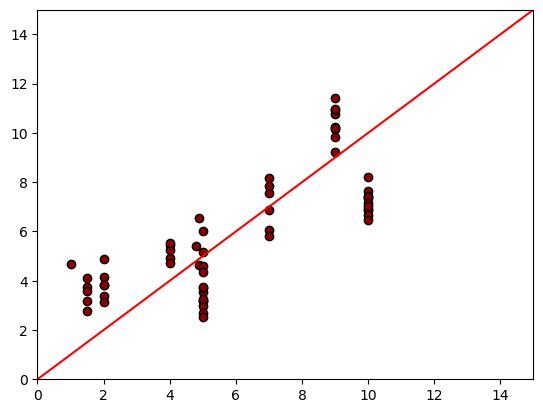

In [10]:
predicted_P=regr_P.predict(x_test_scaled)
plt.plot( y_test_P, predicted_P, 'ok', mfc='darkred')
plt.plot([0, 30], [0, 30], '-r')
lowP=y_test_P<15
Stats_P=pt.calculate_R2_np(y_test_P.loc[lowP].values, predicted_P[lowP])
print(Stats_P['R2'])
plt.xlim([0, 15])
plt.ylim([0, 15])

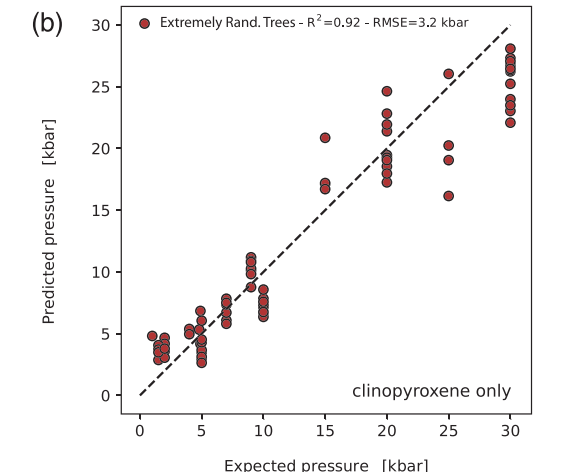

In [ ]:
## 2023 calibration

# from pickle import dump
# import pickle
# dump(scaler, open('scaler_Petrelli2020_Cpx_Only_sklearn_1_3.pkl', 'wb'))
# import joblib
# joblib.dump(regr_P,  'ETR_Press_Petrelli2020_Cpx_Only_sklearn_1_3.pkl',compress=3)
# joblib.dump(regr_T,  'ETR_Temp_Petrelli2020_Cpx_Only_sklearn_1_3.pkl',compress=3)

['ETR_Temp_Petrelli2020_Cpx_Only_sklearn_1_3.pkl']

In [ ]:
## 2025 calibration
from pickle import dump
import pickle
dump(scaler, open('scaler_Petrelli2020_Cpx_Only_sklearn_1_6_1.pkl', 'wb'))
import joblib
joblib.dump(regr_P,  'ETR_Press_Petrelli2020_Cpx_Only_sklearn_1_6_1.pkl',compress=3)
joblib.dump(regr_T,  'ETR_Temp_Petrelli2020_Cpx_Only_sklearn_1_6_1.pkl',compress=3)